In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as SKMeans

# K Means

## 1. Top-Level

### 1.1 High-level explanation

K means is an unsupervised clustering algorithm which will attempt to find the center of "like features" based on the summed euclidean distance of all data given. This algorithm is greedy in the sense that its decision to group things is absolute. Consider the example below of two Gaussian clouds. We assume that a K means algorithm found the center of the clusters to be $(-2,-2)={\rm Blue}$, and $(2,2)={\rm Red}$. We then get a new data point at location $(0,0.1)$, shown in black, and we ask "What cluster does this point belong to?"

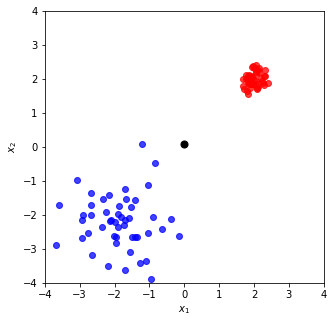

In [63]:
X = np.zeros(shape=(100,2))
Y = np.zeros(shape=(100))
X[:50,:] = np.random.randn(50,2)/5 + 2
X[50:,:] = np.random.randn(50,2)/1.2- 2
Y[:50] = 1
plt.figure(figsize=(5,5))
plt.scatter(X[Y==0,0], X[Y==0,1], color='b', alpha=.75)
plt.scatter(X[Y==1,0], X[Y==1,1], color='r', alpha=.75)
plt.scatter([0], [0.1], color='black', s=50)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

To find which cluster this new data point would belong to, we find the euclidean distance to the centers.

$$
\begin{align*}
\Delta_b &=  \sqrt { \sum_i \left( c^b_i - x_i \right)^2 } \\
&= 2.9 \\ \\[5mm]
\Delta_r &=  \sqrt { \sum_i \left( c^r_i - x_i \right)^2 } \\ 
&= 2.76
\end{align*}
$$

Because $\Delta_r < \Delta_b$ we say (with 100% confidence) that the new data point belongs to the ${\rm Red}$ cluster.

### 1.2 What scenario should you use K means?

K means is a general-purpose clustering approach. It can be used when even sized, spherical clusters can be assumed. It preforms best when there are only a few clusters.

### 1.3 What types of features does the model use?

The model makes the assumption that the data is clustered into spherical groups. Text, and continious data

### 1.4 When does  the model break?
The model will break when the data does not fall into spherical groups. For example, consider two elliptical cluster:

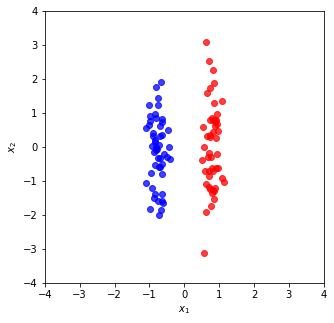

In [69]:
X = np.zeros(shape=(100,2))
Y = np.zeros(shape=(100))
X[:50,:] = np.transpose([np.random.randn(50,1)/6 + .75, np.random.randn(50,1)])
X[50:,:] = np.transpose([np.random.randn(50,1)/6 - .75, np.random.randn(50,1)])
Y[:50] = 1
plt.figure(figsize=(5,5))
plt.scatter(X[Y==0,0], X[Y==0,1], color='b', alpha=.75)
plt.scatter(X[Y==1,0], X[Y==1,1], color='r', alpha=.75)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

We run SK-learn's Kmeans algorithm on the input data, to find the predicted categories:

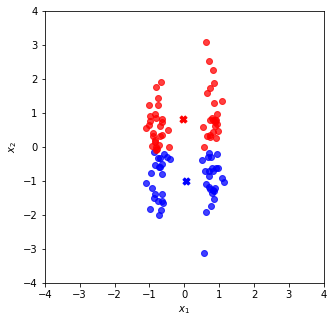

In [72]:
kmeans = SKMeans(2, algorithm='elkan')
Y_hat = kmeans.fit_predict(X)

plt.figure(figsize=(5,5))
plt.scatter(X[Y_hat==0,0], X[Y_hat==0,1], color='b', alpha=.75)
plt.scatter(X[Y_hat==1,0], X[Y_hat==1,1], color='r', alpha=.75)
Cb, Cr = kmeans.cluster_centers_
plt.scatter(Cb[0], Cb[1], color='b', marker='X', s=50)
plt.scatter(Cr[0], Cr[1], color='r', marker='X', s=50)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

The "X-marker" marks the predicted centers of the ${\rm Red}$ and ${\rm Blue}$ clusters. We can see it's converged to an incorrect location, despite there being an obvious separation of the data.  

### 1.5 What to use when it breaks? Whats a good back up?

It depends on how the method breaks:

Sklearn has a good table on the use cases and fall-back models for clustering:

http://scikit-learn.org/stable/modules/clustering.html


One fix that is worth talking about in more detail is to use "soft kmeans," also called "Fuzzy Clustering". Soft kmeans will take into account the distance of a point from the centroid, thereby assigning a "confidence" to the value belonging to that cluster. This can be important for handling outliers, as in the first example. Soft kmeans is described more below.

## 2. A bit more detail

### 2.1 Normalize  of data

Because we're concerned with euclidean distance,

$$
\Delta = \sqrt{ (x-\mu_x)^2 + (y-\mu_y)^2 },
$$

if the coordinates have a different scaling, then k means will preferentially cluster the point on the axis with shorter distance.

In the end this depends on the data: latitude and longitude should not scaled, because this will cause distortions.


### 2.2 How to initialize parameters?

K means has a tendency of converging to a local minima. To get around this, the algorithm is typically run multiple times, with cluster initializes in random locations. 

### 2.3 What's the loss function used?

Soft and hard Kmeans algorithms implement coordinate descent (not gradient descent), such that the center of the centroid is updated based on the mean (or weighted mean) of the data points assigned to that cluster. Because both of these functions are monotonically decreasing, kmeans is guaranteed to converge; however, it will probably converge to a local minima.

#### 2.3.1 Hard Kmeans

The loss function for hard kmeans is the 

$$
\mu_i \leftarrow \cfrac{\sum_i x_i}{\sum_i i}
$$


#### 2.3.1 Soft Kmeans

In soft k means, the loss function is weighted by a probability that the data point belongs to that cluster, denoted the 'responsibility', $r$.

$$
\mu_i \leftarrow \cfrac{\sum_i r_i x_i}{\sum_i r_i }
$$

with

$$
r_{ij} = \cfrac{ \exp \left \{ \beta \delta(\mu_j, x_{ij}) \right \}}{\sum_i \exp \left \{ \beta \delta(\mu_j, x_{ij}) \right \} }
$$

$\delta$ being the euclidean distance between a point x_i and the closest centroid, $\mu$, and $\beta$ is a weighting constant (I think usually it's just set to 1).


### 2.4 What's the complexity? Does it scale?

The complexity of the problem is of the order 

$$
\mathcal{O}(I\cdot N\cdot D \cdot C)
$$

wherein $I$ is iterations; $N$ is number of data points; $D$ is dimensions; and $C$ is the number of clusters. Some short cuts can be taken, such as only taken a small sample of the total number of data points, but overall, Kmeans does not scale very well. 

## 3. In-depth

### 3.1 Derive the math

The math behind kmeans is quite simple, and there's nothing really to derive, so we'll just do a simple step-by-step example. Say we have data that we're trying to cluster, we drop two centroids onto the data at random locations:

To converge on the clusters we will do the following steps:

 1. Calculate the distance from every single data point to centroid 1 and centroid 2
 2. Assign each data point to the centroid that it is closer to
 3. For every single data point assigned to a cluster, take the mean value $\frac{1}{N}\sum_i (x_i, y_i)$
 4. Move the centroid to this coordinate
 5. Repeat

### 3.2 Simple implementation

In [131]:
class Kmeans:
    
    def __init__(self, clusters):
        self._num_clusters = 2
    
    @property
    def centroids(self):
        return self._centroids
    
    def fit(self, X, epochs=10):
        N, D = X.shape
        self._centroids = X.max(axis=0)*np.random.random((self._num_clusters, D))
        Y = np.zeros(N)
        _deltas = np.zeros((self._num_clusters, N))
        
        # Repeate for the number of specified iterations
        for _ in range(epochs):
            
            # Find the eculidian distance
            for c in range(self._num_clusters):
                _deltas[c,...] = np.sqrt(
                    np.sum(
                        np.subtract(self._centroids[c,...], X)**2, 
                        axis=1
                    )
                )
            
            # Assign the data with minimum distances to the respective centroids
            Y = np.argmin(_deltas, axis=0)
            
            # Update the centroid locations based on the mean of the assigned clusters
            for c in range(self._num_clusters):
                self._centroids[c,...] = X[Y==c].mean(axis=0)
    
        return Y

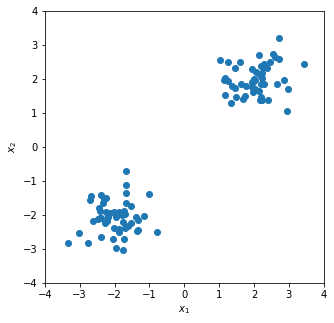

In [132]:
X = np.zeros(shape=(100,2))
X[:50,:] = np.random.randn(50,2)/2 + 2
X[50:,:] = np.random.randn(50,2)/2 - 2
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

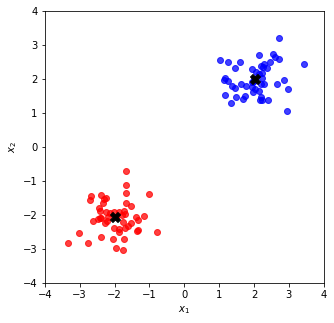

In [137]:
kmeans = Kmeans(clusters=2)
Y = kmeans.fit(X)
C = kmeans.centroids

plt.figure(figsize=(5,5))
plt.scatter(X[Y==0,0], X[Y==0,1], color='b', alpha=.75)
plt.scatter(X[Y==1,0], X[Y==1,1], color='r', alpha=.75)
plt.scatter(*C.T, color='black', marker='X', s=100)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

## 4. More on training the model

#### 4.1 How can you validate the model?